In [86]:
import numpy as np
import os
import re
import pandas as pd
from tqdm import tqdm_notebook 
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding, TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, mutual_info_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, BatchSampler, Sampler
from utils import calc_gradient_magnitude
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

r2_scorer = make_scorer(r2_score)

from utils import shuffle
from joblib import Parallel, delayed 

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)

In [2]:
def similarity_metric(x1,x2, metric_type='cos'):
    '''
    correlate by neural activations
    x1: [time1,n_cells]
    x2: [time2,n_cells]
    '''
    n_cells = x1.shape[1]
    
    if metric_type == 'cos':
        norms = (np.linalg.norm(x1,axis=1)[:,None] @ np.linalg.norm(x2,axis=1)[:,None].T)
        V = (x1-x1.mean(1)[:,None])@(x2 - x2.mean(1)[:,None]).T / norms        
    return V

In [3]:
# track = 'Circle'

# for mouse in [22,23,25,25]:
#     for day in [1,2,3]:

#         spikes_df = pd.read_csv(f"./Data_Calcium/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
#         # spikes_events_df = pd.read_csv(f"./Data_Calcium/{track}/spikes/CA1_{mouse}_1D_initial_data_spikes.csv", index_col=0) 
#         print('n_steps', 'n_electrodes', spikes_df.shape)

In [4]:
track = 'Circle'
mouse = 22
day = 1
spikes_df = pd.read_csv(f"./Data_Calcium/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
trim=100
spikes_df = spikes_df[trim:-trim]

X_neural = spikes_df.iloc[:,7:].to_numpy()
X_neural_std = StandardScaler().fit_transform(X_neural)
time = spikes_df['time_s'].values
N = len(time)
n_neurons = X_neural.shape[1] 

In [64]:
spikes_df.shape, X_neural_std.shape

((18575, 556), (18575, 549))

# Coordinates

In [5]:
X = spikes_df["x"].to_numpy()
Y = spikes_df["y"].to_numpy()
X_green = spikes_df["x_green"].to_numpy()
Y_green = spikes_df["y_green"].to_numpy()
X_red = spikes_df["x_red"].to_numpy()
Y_red = spikes_df["y_red"].to_numpy()

coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
phi = np.arctan2(coords_[:,0], coords_[:,1]) + np.pi

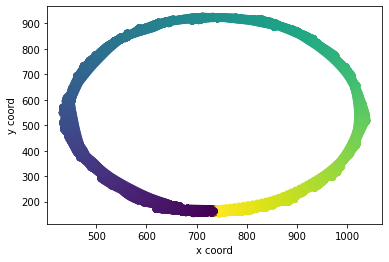

In [61]:
plt.scatter(X,Y, c=phi, label='color->time')
plt.xlabel('x coord')
plt.ylabel('y coord')
# plt.legend()
plt.show()

In [7]:
# kde_phi = KernelDensity(bandwidth=0.01)
# kde_phi.fit(coords_)
# sample = kde_phi.sample(1000)
# plt.scatter(sample[:,0], sample[:,1])
# plt.scatter(coords_[:,0], coords_[:,1], alpha=0.01)

# Correlation

In [8]:
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances

def kth_diag_indices(rows, cols, k):
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [9]:
C_all_time = pairwise_distances(coords_)
C_all_time = 1 - MinMaxScaler().fit_transform(C_all_time)

In [11]:
V_all_time = similarity_metric(X_neural_std, X_neural_std)
# null diagonal indexes 
rows, cols = np.diag_indices_from(V_all_time)
diagonal_dt = 200
for k in np.arange(-diagonal_dt,diagonal_dt + 1):
    ind = kth_diag_indices(rows, cols, k)
    V_all_time[ind] = 0

In [12]:
V_all_time_bin = V_all_time.copy()
threshold = 0.4
V_all_time_bin[V_all_time_bin > threshold] = 1
V_all_time_bin[V_all_time_bin <= threshold] = 0

In [13]:
print('Correlation mass preserved after coordinate correlation weighting for BIN:', (V_all_time_bin*C_all_time).sum()/ (V_all_time_bin).sum())

Correlation mass preserved after coordinate correlation weighting for BIN: 0.9222373799131197


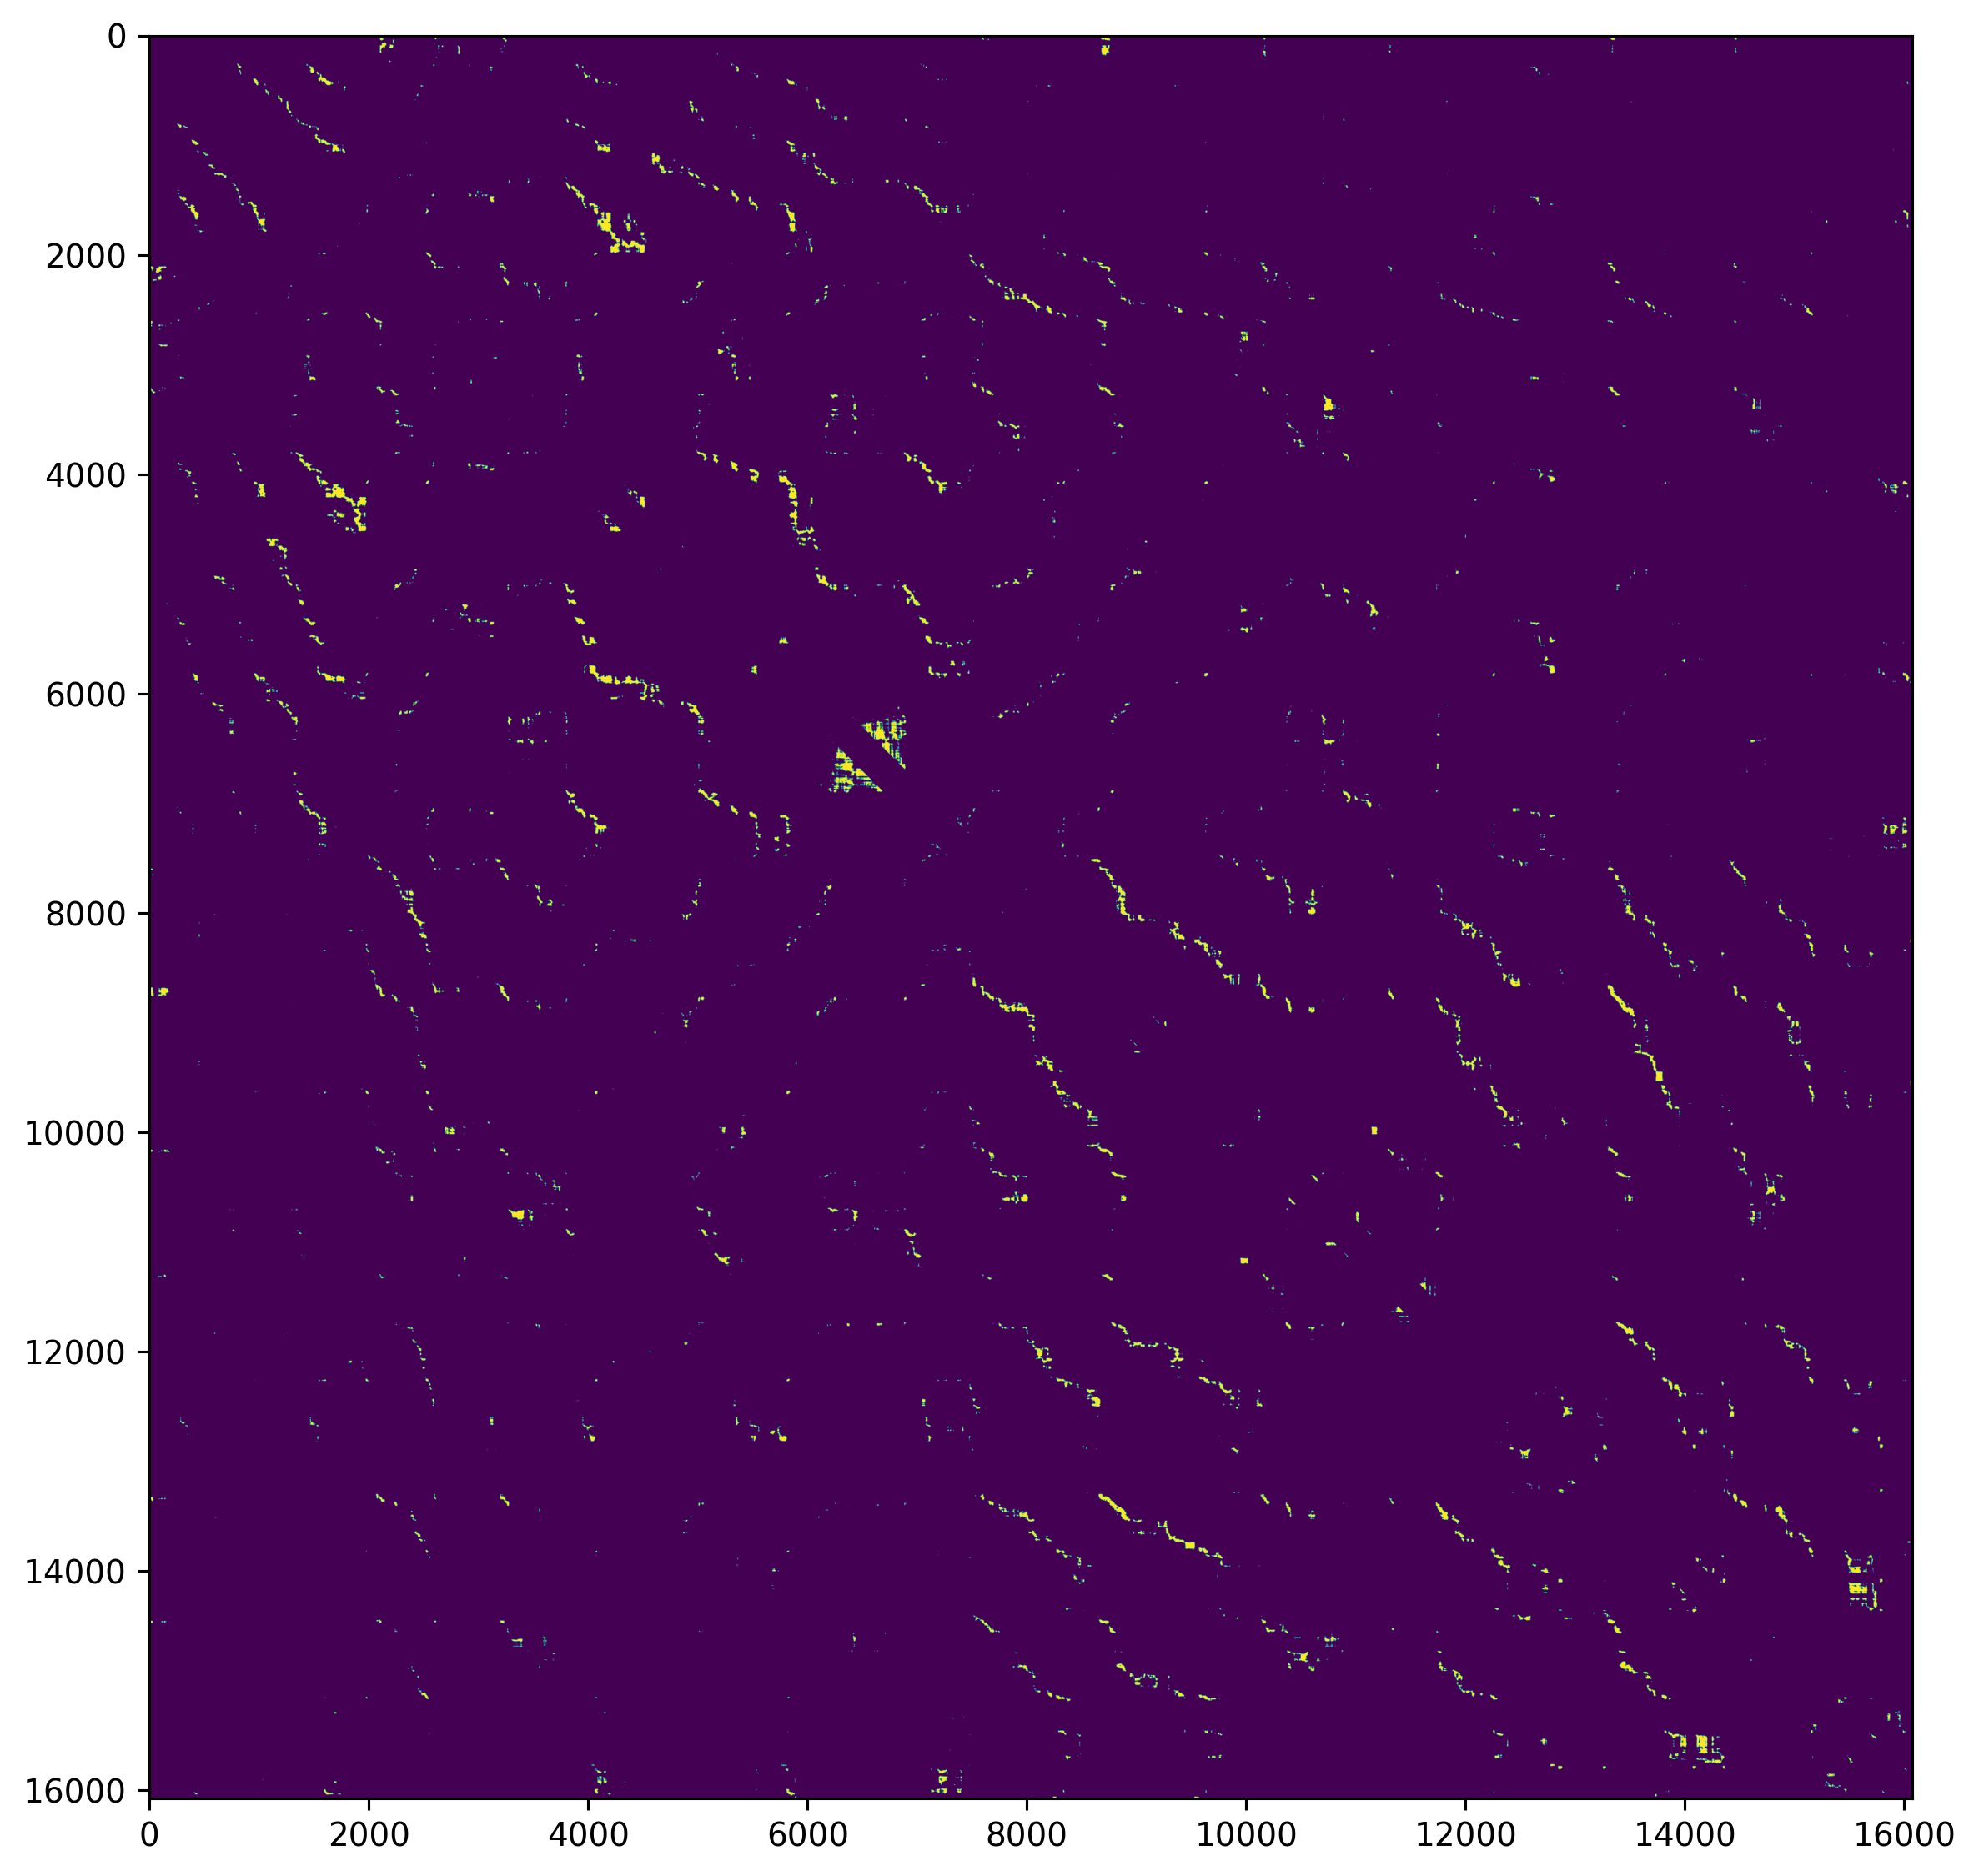

In [14]:
plt.figure(figsize=(10,10), dpi=280)
plt.imshow(V_all_time_bin[2500:, 2500:])
plt.show()

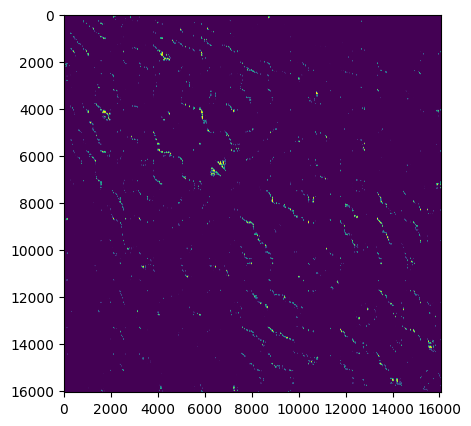

In [15]:
plt.figure(figsize=(5,5), dpi=100)
selection_start = 2500
selection_stop = V_all_time_bin.shape[0]
V_all_time_selected = V_all_time_bin[selection_start:selection_stop, selection_start:selection_stop] # (V_all_time_bin * C_all_time*0.3)
X_neural_std_selected = X_neural_std[selection_start:selection_stop]
phi_selected = phi[selection_start:selection_stop]
plt.imshow(V_all_time_selected)
plt.show()

In [16]:
del V_all_time, V_all_time_bin

# Select correlated patterns

In [17]:
n_selected = V_all_time_selected.shape[0]
correlated_pairs_indexes = np.stack(np.meshgrid(np.arange(selection_start, selection_stop),
                                                np.arange(selection_start, selection_stop)), -1)[V_all_time_selected.astype(bool)]

In [25]:
correlated_pairs_indexes.shape

(1905898, 2)

In [26]:
dbscan = DBSCAN(eps=30.)
y = dbscan.fit_predict(correlated_pairs_indexes)
not_noise_mask = y!=-1

In [27]:
print('Clusters found', len(np.unique(y[not_noise_mask])))
print('Non-Noise ratio', sum(not_noise_mask)/len(not_noise_mask))

Clusters found 1538
Non-Noise ratio 0.9998341988920708


In [28]:
# np.save(f'dbscan_pred_{track}_{mouse}_{day}_{selection_start}_{selection_stop}',y)

In [29]:
y_non_noise= y[not_noise_mask]
correlated_pairs_indexes_non_noise = correlated_pairs_indexes[not_noise_mask]

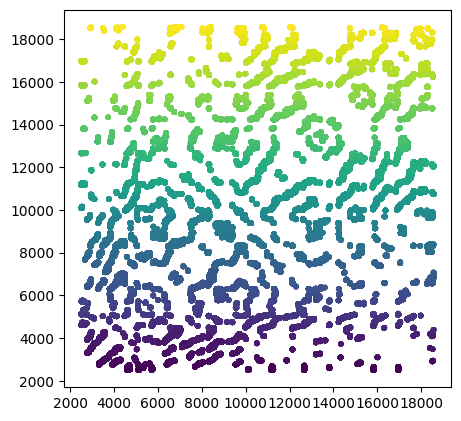

In [30]:
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(correlated_pairs_indexes_non_noise[:,0], correlated_pairs_indexes_non_noise[:,1], c=y_non_noise, marker='.')
plt.show()

In [31]:
patterns_all = []
phi1 = []
phi2 = []

for cluster_number in np.unique(y_non_noise):
    mask = y_non_noise==cluster_number
    pattern_pair_indexes = correlated_pairs_indexes_non_noise[mask]
    ind1 = np.unique(pattern_pair_indexes[:,0])
    ind2 = np.unique(pattern_pair_indexes[:,1])
    
    pattern1 = X_neural_std[ind1]
    pattern2 = X_neural_std[ind2]
    
    phi1.append(phi[ind1])
    phi2.append(phi[ind2])

    patterns_all.append(pattern1)
    patterns_all.append(pattern2)

patters have high length variance

In [32]:
len(patterns_all)

3076

In [44]:
phi1_mean = [p.mean() for p in phi1]
phi2_mean = [p.mean() for p in phi2]

phi_all = []
for i in range(len(phi1)):
    
    phi_all.append(phi1[i])
    phi_all.append(phi2[i])


phi_all_mean = [p.mean() for p in phi_all]

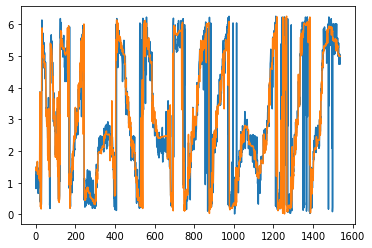

In [40]:
plt.plot(phi1_mean)
plt.plot(phi2_mean)

In [34]:
patterns_all_mean = np.stack([p.mean(0) for p in patterns_all])

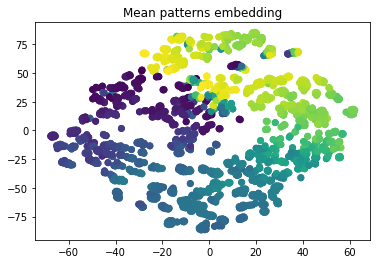

In [60]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, random_state=42, n_jobs=-1)
patterns_all_mean_tsne = tsne.fit_transform(patterns_all_mean)
plt.figure()
plt.scatter(patterns_all_mean_tsne[:,0], patterns_all_mean_tsne[:,1], c=phi_all_mean)
plt.title('Mean patterns embedding')
plt.show()

In [96]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import MinimalFCParameters
settings = MinimalFCParameters()

In [80]:
id_patterns = np.concatenate([np.ones(p.shape[0])*i for i,p in enumerate(patterns_all)])
time_patterns = np.concatenate([np.arange(p.shape[0]) for i,p in enumerate(patterns_all)])
patterns_all_cat = np.concatenate(patterns_all, 0)
patters_timeseries = pd.DataFrame(patterns_all_cat)

In [82]:
patters_timeseries['id'] = id_patterns
patters_timeseries['time'] = time_patterns

In [99]:
extracted_pattern_features = extract_features(patters_timeseries, 
                                              column_id="id", 
                                              column_sort="time", 
                                              n_jobs=4,
                                              default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 20/20 [05:30<00:00, 16.51s/it]


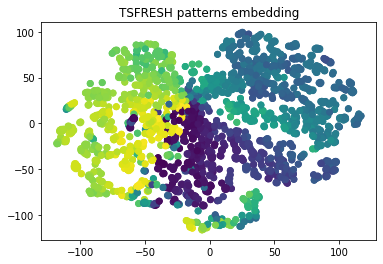

In [105]:
tsne = TSNE(n_components=2, perplexity=20, n_iter=2000, random_state=42, n_jobs=-1)
patterns_all_tsfresh_tsne = tsne.fit_transform(extracted_pattern_features)
plt.figure()
plt.scatter(patterns_all_tsfresh_tsne[:,0], patterns_all_tsfresh_tsne[:,1], c=phi_all_mean)
plt.title('TSFRESH patterns embedding')
plt.show()

# Patterns clusterization: LSTM

In [112]:
class AE_LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.hidden2input = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, sequence, hidden=None):
    
        out, hidden_out = self.encoder(sequence, hidden) if hidden is not None else self.encoder(sequence)
#         out = out[:,-1]
        
        return out
    
    def decode(self, x, n_steps_predict):
        results = []
        hidden_out = None
        seq = x.unsqueeze(1) # fake time dimension
        for i in range(n_steps_predict):
            seq, hidden_out = self.decoder(seq, hidden_out)
            x = self.hidden2input(seq.squeeze(1))
            results.append(x)
        return torch.stack(results, 1)

In [113]:
def encoding_pass(model, seq_batch):
    sequences = [torch.FloatTensor(s).cuda() for s in seq_batch]
    lengths = [p.shape[0] for p in sequences]
    sequences_padded = pad_sequence(sequences, batch_first=True)
    packed = pack_padded_sequence(sequences_padded, lengths, batch_first=True, enforce_sorted=False)#.cuda()
    
    out = model.encode(packed)
    out_padded, lengths_out = pad_packed_sequence(out, batch_first=True)
        
    assert lengths_out.tolist() == lengths    
    
    codes = [out_p[l-1] for out_p, l in zip(out_padded,lengths_out)]
    
    return sequences, codes, lengths

    
def reconstruction_loss(model, sequences, codes, lengths):
    
    loss = 0
    for i,(code, length) in enumerate(zip(codes, lengths)):
        seq_rec = model.decode(code.unsqueeze(0), length)
        loss += mae_score_torch(sequences[i].unsqueeze(0), seq_rec).mean()
    return loss / len(lengths)

In [114]:
def mae_score_torch(y, y_pred, EPS=1e-5):
    eps = torch.ones_like(y, device=y.device)*EPS
    denominator =  torch.max(torch.stack([torch.abs(y), eps], -1), -1)[0]
    return torch.abs(y_pred - y) / denominator

In [115]:
def make_batch_generator(data, batch_size, shuffle=True):
        
    data_copy = data.copy()
    if shuffle:
        np.random.shuffle(data_copy)
    splits = len(data_copy) // batch_size
    for i in range(splits):
        yield data_copy[i*batch_size:(i+1)*batch_size]

In [116]:
latent_dim = 1024
model = AE_LSTM(n_neurons, latent_dim).cuda()
optimizer = Adam(model.parameters(), lr=1e-4)
epochs = 1000
clip_grads=True
MAX_GRAD = 1e-1
batch_size=256

patterns_train, patterns_test =  train_test_split(patterns_all, shuffle=True, random_state=42)

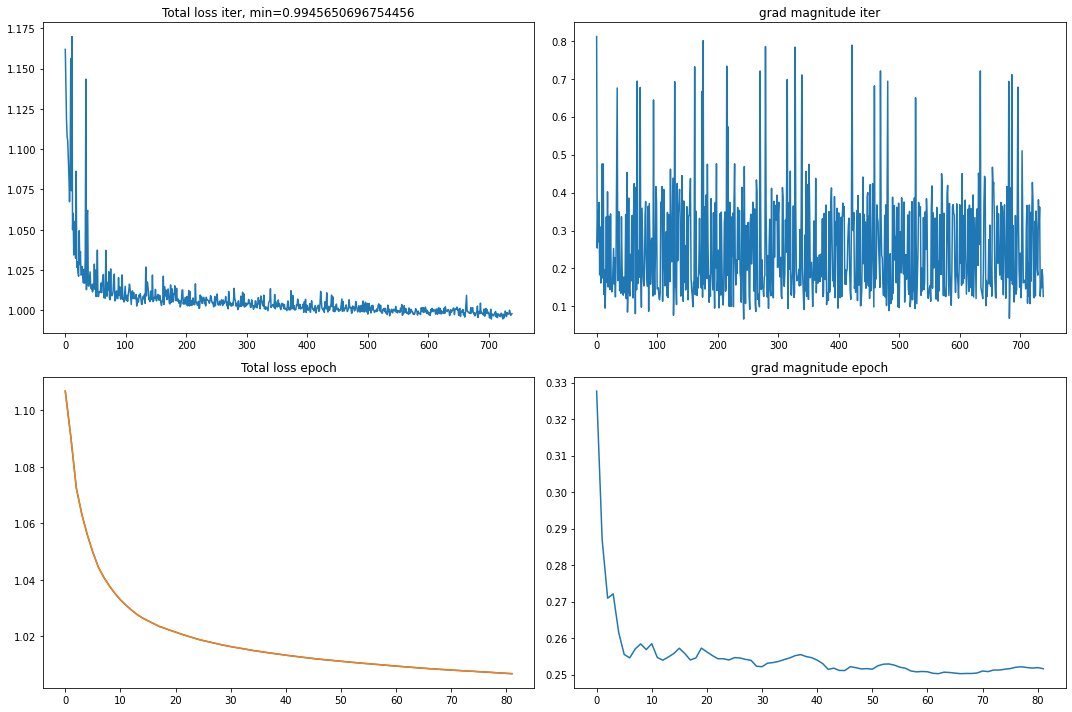

In [ ]:
history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in range(epochs):
    model.train()
    patterns_train_generator = make_batch_generator(patterns_train, batch_size=batch_size, shuffle=True)
    patterns_test_generator = make_batch_generator(patterns_test, batch_size=batch_size, shuffle=False)
    for itr, seq_batch in enumerate(patterns_train_generator):
        
        optimizer.zero_grad()
        sequences, codes, lengths = encoding_pass(model, seq_batch)
        train_loss = reconstruction_loss(model, sequences, codes, lengths)
        train_loss.backward()
            
        # metrics
        if clip_grads:
            MAX_GRAD = 1
            torch.nn.utils.clip_grad_value_(model.parameters(), MAX_GRAD)
            assert max([param.grad.abs().max().item() for param in model.parameters()]) <= MAX_GRAD

        grad_magnitude = calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                              model.named_parameters()), silence=False)

        # perform parameter update based on current gradients
        optimizer.step()

        history_train['total_loss'].append(train_loss.item())
        history_train['grad_magnitude'].append(grad_magnitude)
        
        if (itr%100) == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
            
            #--------TRAIN
            axes[0,0].plot(history_train['total_loss'])
            minloss = min(history_train['total_loss'])
            axes[0,0].set_title(f'Total loss iter, min={minloss}')

            axes[0,1].plot(history_train['grad_magnitude'])
            axes[0,1].set_title(f'grad magnitude iter')
            
            
            #----------EPOCH
            if epoch > 0:
                axes[1,0].plot(history_train['total_loss_epoch'], label='train')
                axes[1,0].plot(history_val['total_loss_epoch'], label='val')
                axes[1,0].set_title(f'Total loss epoch')

                axes[1,1].plot(history_train['grad_magnitude_epoch'], label='train')
                axes[1,1].set_title(f'grad magnitude epoch')

                plt.tight_layout()
            plt.show()
            

    # END of the epoch
    history_train['total_loss_epoch'].append(np.mean(history_train['total_loss'][-len(patterns_train):]))
    history_val['total_loss_epoch'].append(np.mean(history_train['total_loss'][-len(patterns_test):]))
    history_train['grad_magnitude_epoch'].append(np.mean(history_train['grad_magnitude'][-len(patterns_train):]))    
    
    # VALIDATE
    model.eval()
    for _, seq_batch in enumerate(patterns_test_generator): 
        
        sequences, codes, lengths = encoding_pass(model, seq_batch)
        test_loss = reconstruction_loss(model, sequences, codes, lengths)
        history_val['total_loss'].append(test_loss.item())
        
    if epoch%250 == 0 and epoch > 0:
        torch.save({'model':model.state_dict(),
                   'optimizer':optimizer.state_dict()}, f'./models/ae_lstm_ep{epoch}_ld{latent_dim}')
            